<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Algorithm 1 - Logistic Regression Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Full Feature Set </h2> 

# Table of Contents

[Introduction](#setup)  
[No Sample Weights](#noweights)    
[Sample Weights](#weights)  
[Cross-Validation and Parameter Tuning](#cross-validation)   
[Logistic Regression Summary](#summary)

# Introduction <a class="anchor" id="setup"></a>

Initially, we will import the necessary libraries for this notebook. It is essential to mention that some customized libraries from this project are included, which possess functions that we have developed to assist in loading and handling data and storing model outcomes.

Moreover, the variables `COUNTRY` and `ALGORITHM_NAME` are set here to guarantee accurate data loading and a standardized method of storing outcomes.

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import recall_score, f1_score, cohen_kappa_score, average_precision_score
from imblearn.metrics import specificity_score

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            load_data)




ALGORITHM_NAME = 'lr'
COUNTRY = 'full_merged_dumvar'

TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

# No Sample Weights <a class="anchor" id="noweights"></a>

We first of all run the model without the sample weights to develop a benchmark model 

CPU times: user 140 ms, sys: 236 ms, total: 375 ms
Wall time: 29.7 ms
CPU times: user 2.7 ms, sys: 32.7 ms, total: 35.4 ms
Wall time: 2.52 ms
In-sample score: 80.20%


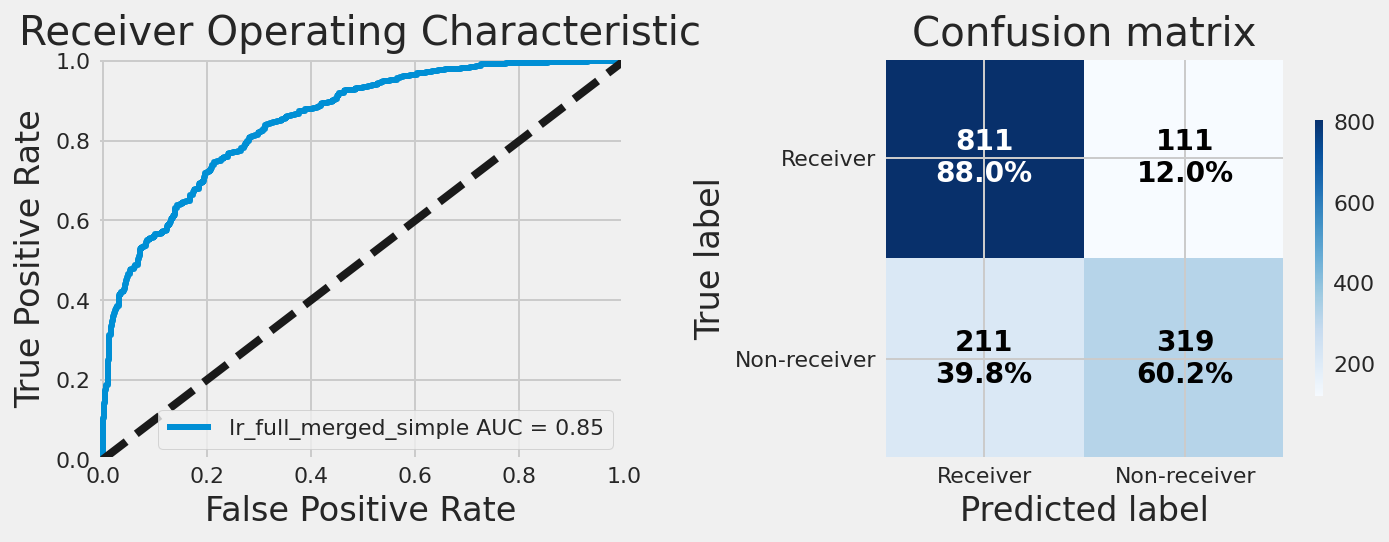

,lr_full_merged_simple
accuracy,0.778237
recall,0.879610
precision,0.793542
f1,0.834362
cross_entropy,0.453834
roc_auc,0.851148
cohen_kappa,0.501616


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 64.09% 


In [2]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression(max_iter=100)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
def get_coefs_df(X, coefs, index=None, sort=True):
    coefs_df = pd.DataFrame(np.std(X, 0) * coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    if sort:
        coefs_df = coefs_df.sort_values('abs', ascending=False)
    return coefs_df

coefs = get_coefs_df(X_train, model.coef_[0])

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    store_model=True,
                                    model_name='full_merged_simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# Sample weights <a class="anchor" id="weights">

Next, we will incorporate the sample weights that came with the dataset, enabling us to generalize our model results to the overall population.

CPU times: user 328 ms, sys: 1.34 s, total: 1.67 s
Wall time: 122 ms
CPU times: user 19.3 ms, sys: 125 ms, total: 145 ms
Wall time: 10.3 ms
In-sample score: 84.36%


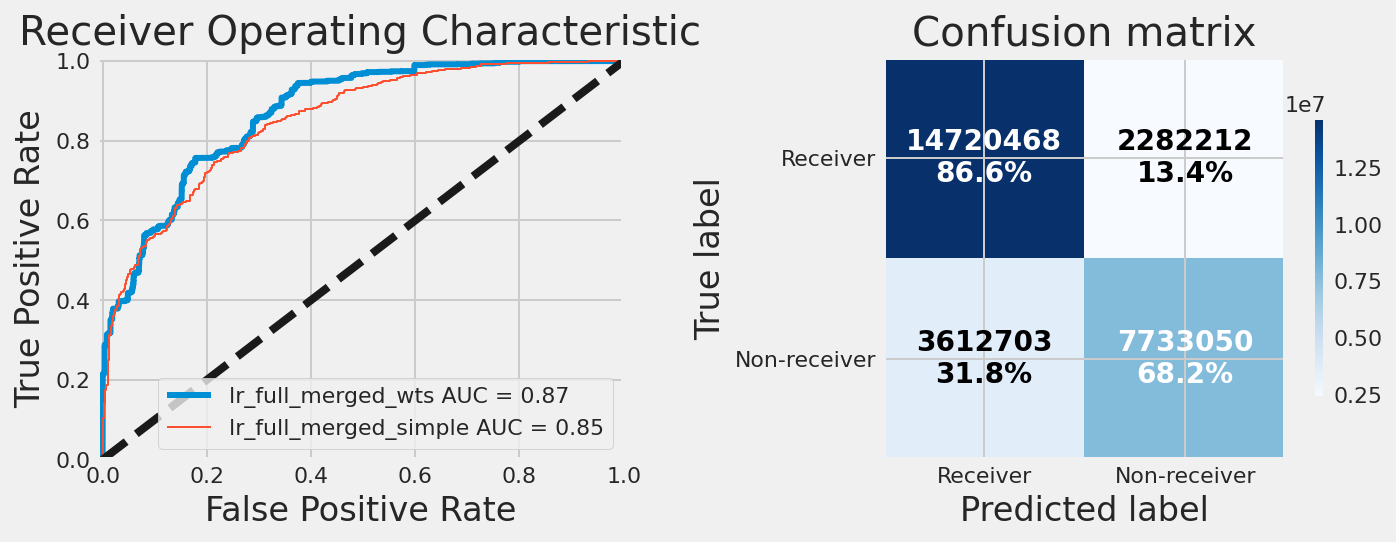

,lr_full_merged_wts,lr_full_merged_simple
accuracy,0.792055,0.778237
recall,0.865773,0.879610
precision,0.802942,0.793542
f1,0.833175,0.834362
cross_entropy,0.433750,0.453834
roc_auc,0.871371,0.851148
cohen_kappa,0.504613,0.501616


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 63.26% 


In [3]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression(max_iter=140)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]


# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full_merged_simple',
                                    store_model=True,
                                    model_name='full_merged_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)
best_model = model

## Cross-validation and Parameter Tuning <a class="anchor" id="cross-validation"></a>

Cross-validation is a commonly used technique when fitting a model. It involves dividing the training set into several different "folds" and fitting the model to each fold. One variation of the LogisticRegression model that includes cross-validation is available in Scikit-Learn and is called LogisticRegressionCV. This function utilizes stratified k-folds, which ensures that each fold of data has the same proportion of the response variable.

Improving model performance can also be done by tuning its parameters. The default regularization applied by Scikit-learn's LogisticRegression model is 'l2', which includes a 'C' parameter that determines the strength of the regularization. Smaller values of 'C' indicate stronger regularization, which can help in improving model results. To simplify the process of finding the best value for 'C', Scikit-Learn provides the LogisticRegressionCV function that enables us to search through multiple values.  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished


CPU times: user 18.2 s, sys: 50 s, total: 1min 8s
Wall time: 4.33 s
CPU times: user 7.21 ms, sys: 31.7 ms, total: 38.9 ms
Wall time: 2.44 ms
In-sample score: 84.35%
Best model parameters: C=0.002364489412645407


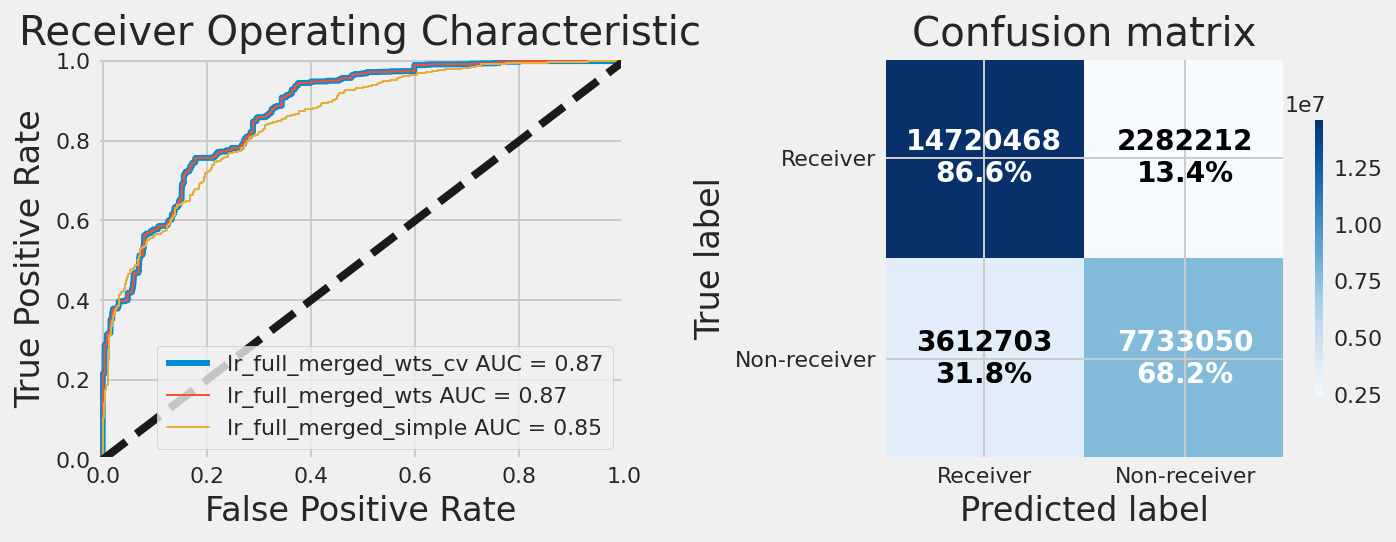

,lr_full_merged_wts_cv,lr_full_merged_wts,lr_full_merged_simple
accuracy,0.792055,0.792055,0.778237
recall,0.865773,0.865773,0.879610
precision,0.802942,0.802942,0.793542
f1,0.833175,0.833175,0.834362
cross_entropy,0.433720,0.433750,0.453834
roc_auc,0.871317,0.871371,0.851148
cohen_kappa,0.504613,0.504613,0.501616


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 63.27% 


In [4]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegressionCV(Cs=100, cv=10, verbose=1, max_iter=500)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])



# Display best parameters
best_params = model.C_[0]
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_merged_wts', 
                                                    'lr_full_merged_simple'],
                                    store_model=True,
                                    model_name='full_merged_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

### Gridsearch with more parameters

Fitting 3 folds for each of 192 candidates, totalling 576 fits
CPU times: user 748 ms, sys: 244 ms, total: 992 ms
Wall time: 1min 31s
CPU times: user 13 ms, sys: 24.3 ms, total: 37.3 ms
Wall time: 3.57 ms
In-sample score: 85.05%
Best model parameters: C={'C': 0.002364489412645407, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


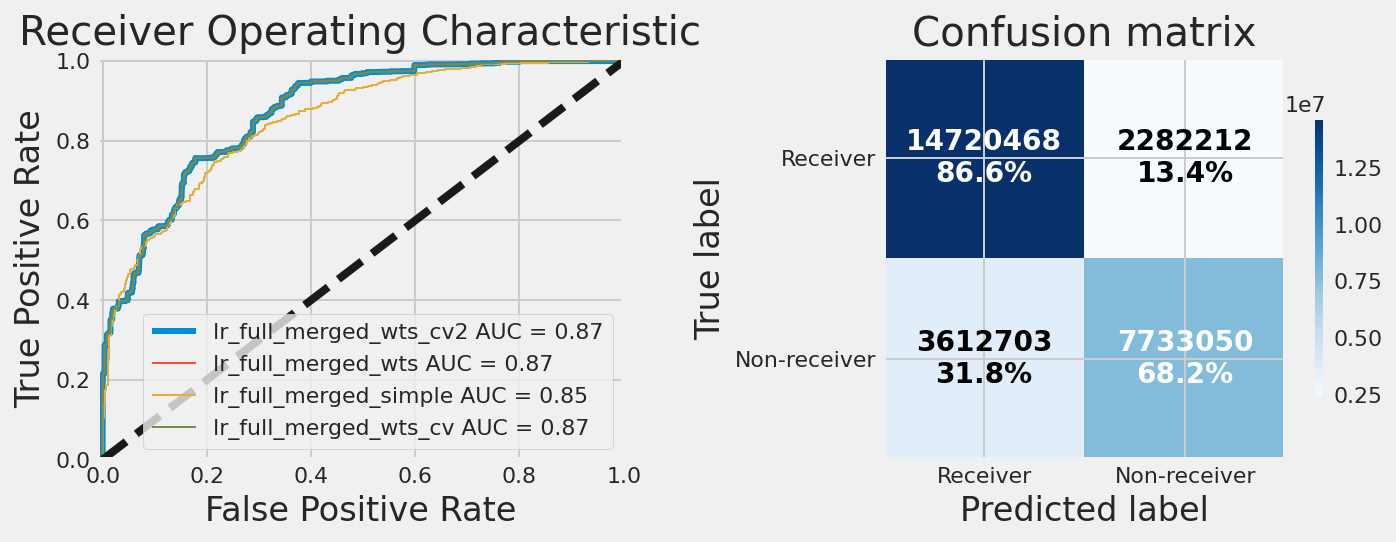

,lr_full_merged_wts_cv2,lr_full_merged_wts,lr_full_merged_simple,lr_full_merged_wts_cv
accuracy,0.792055,0.792055,0.778237,0.792055
recall,0.865773,0.865773,0.879610,0.865773
precision,0.802942,0.802942,0.793542,0.802942
f1,0.833175,0.833175,0.834362,0.833175
cross_entropy,0.433700,0.433750,0.453834,0.433720
roc_auc,0.871313,0.871371,0.851148,0.871317
cohen_kappa,0.504613,0.504613,0.501616,0.504613


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 63.27% 


In [5]:
scorers = {
    'kappa': make_scorer(cohen_kappa_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(average_precision_score),
    'specificity': make_scorer(specificity_score)
}

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
estimator = LogisticRegression(penalty='l2', C=1, solver='liblinear', class_weight='balanced', max_iter=3000, 
                           random_state=8)
parameters = {'penalty': [None, 'l1', 'l2', 'elasticnet'],
              'solver': ['lbfgs', 'liblinear', 'saga'],
              'C': [0.000236448941264540, 0.002364489412645407, 0.01, 0.1],
              'class_weight': [None, 'balanced', {0:1.7/2.7, 1:1/2.7}, {0:2/3, 1:1/3}]}

# Use stratified KFold for the cross-validation given the imbalanced data
kf = StratifiedKFold(n_splits=3)

model = GridSearchCV(estimator, parameters, scoring=scorers, refit='f1', verbose=1, cv=kf, n_jobs=-1)

%time model.fit(X_train, y_train, sample_weight=w_train)


# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.best_estimator_.coef_[0])

model.best_estimator_

# Display best parameters
best_params = model.best_params_
print("Best model parameters: C={}".format(best_params))

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.best_estimator_.predict(X_test)
y_prob = model.best_estimator_.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_merged_wts', 
                                                    'lr_full_merged_simple',
                                                    'lr_full_merged_wts_cv'],
                                    store_model=True,
                                    model_name='full_merged_wts_cv2', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

In [6]:
model.best_estimator_

LogisticRegression(C=0.002364489412645407, max_iter=3000, penalty='l1',
                   random_state=8, solver='liblinear')

In [7]:
model.best_score_

0.8440783051022002

In [8]:
# from sklearn.calibration import calibration_curve
# y_test_predict_proba = model.predict_proba(X_test)[:, 1]
# fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)
# plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Uncalibrated')

# Logistic Regression Coefficients <a class="anchor" id="coefficient"></a>

In [9]:
coefs[0:30]

,coef_std,coef,abs
account__1,1.106742,2.760691,1.106742
fin33__2.0,-0.511249,-1.209150,0.511249
economy__17,0.426925,1.546289,0.426925
merchantpay_dig__1.0,0.371023,0.797406,0.371023
educ__3,0.365319,1.161154,0.365319
fin22a__2,-0.317423,-0.867682,0.317423
economy__13,0.303181,1.250621,0.303181
fin17a__2,-0.289396,-0.630444,0.289396
economy__8,0.273748,1.197157,0.273748
economy__12,0.265865,1.357333,0.265865


In [10]:
coefs[30:62]

,coef_std,coef,abs
economy__16,0.084471,0.636837,0.084471
fin22b__2,0.084017,0.168038,0.084017
fin24__7,-0.075879,-0.297746,0.075879
fin24__4,0.070977,0.240930,0.070977
inc_q__4,0.067578,0.164058,0.067578
mobileowner__2,0.065045,0.203486,0.065045
economy__18,0.060108,0.528808,0.060108
emp_in__2.0,0.054046,0.181534,0.054046
economy__21,0.053884,0.278970,0.053884
internetaccess__2,-0.051348,-0.105025,0.051348


# Logistic Regression Summary <a class="anchor" id="summary"></a>
In this notebook, we have covered the basic concepts of a logistic regression classifier, and applied it to our dataset. We also explored some techniques for analyzing the performance of our model as well as tuning parameters. 

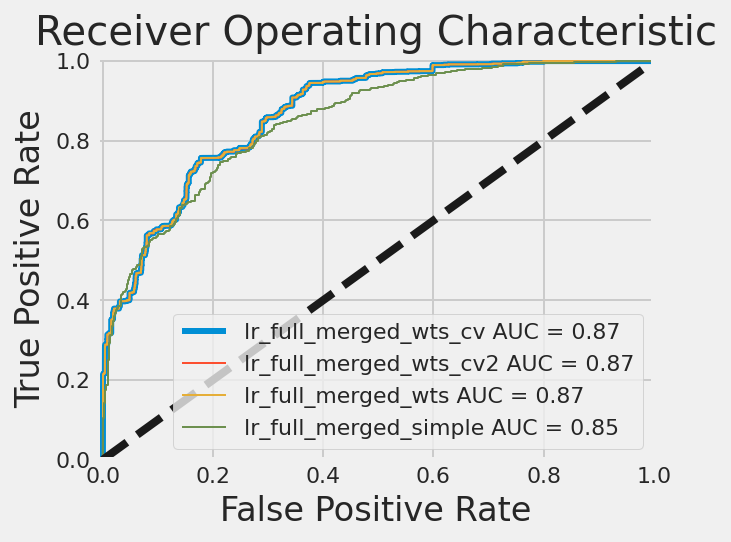

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa
lr_full_merged_wts_cv,0.792055,0.865773,0.802942,0.833175,0.433720,0.871317,0.504613
lr_full_merged_wts_cv2,0.792055,0.865773,0.802942,0.833175,0.433700,0.871313,0.504613
lr_full_merged_wts,0.792055,0.865773,0.802942,0.833175,0.433750,0.871371,0.504613
lr_full_merged_simple,0.778237,0.879610,0.793542,0.834362,0.453834,0.851148,0.501616


In [11]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)